# Notebook 2 – Pulizia e Sistemazione Dati

Questo notebook è dedicato alla fase di pulizia, esplorazione e preparazione dei dati necessari per il nostro progetto **Temperature moderate ed estreme e rischio climatico-sanitario a Bologna**, sviluppato secondo la metodologia descritta da Gasparrini et al. (2015) e integrato nel contesto del progetto del Prof. Ciancarini e la Prof.ssa Lodi.

## Scopo del notebook


1.   **Pulire e trasformare i dati grezzi**:

  - Correzione dei tipi di variabili (date, numeri)
  - Rimozione di colonne inutili (come vedremo nel caso di `df_demo`).
  - Aggregazione di dati demografici per fasce d’età (`over65`, `under5`)
  - Creazione delle variabili di popolazione totale (`numPeople`) e percentuali di gruppi vulnerabili (`pct_under5`, `pct_over65`, `mortality_risk_pct`)

2. **Integrare fonti dati differenti**:

  - **Temperature medie giornaliere a Bologna** (`df_temp`)
  - **Dati demografici ISTAT** (`df_demo`)
  - **Percentuali di mortalità associate alle condizioni termiche** (`df_death`)

3. **Classificare le giornate climaticamente**:

  1. Extreme Cold `ec`
  2. Moderate Cold `mc`
  3. Moderate Heat `mh`
  4. Extreme Heat `eh`

Utilizzando le soglie calcolate sui dati di Bologna (percentili 2.5°, 97.5° e temperatura ottimale mediana).

4. **Calcolare una stima più realistica del rischio di mortalità:**

  - Per `mc` e `mh`, il rischio lo consideriamo come non costante ma aumenta man mano che la temperatura si allontana dalla temperatura ottimale. Per `ec` ed `eh` abbiamo invece scelto di lasciare la stima fatta dal lavoro di Gasparrini et al. (2015), sopratutto dper il fatto che non ci sono tanti dati.
  - Applichiamo quindi una proporzione dinamica per simulare meglio il rischio legato ai giorni moderatamente freddi o caldi.

5. **Preparare il dataset finale:**

  -  Abbiamo creato il file **bolognaRiskDataset.csv**, completo di:
    - Temperature giornaliere
    - Fascia climatica classificata
    - Popolazione totale `numPeople`, `over65` e `under5`
    - Percentuali di rischio mortalità stimate
    - Codifica numerica per `season` e `temp_category`

  ***Questo dataset sarà utilizzato nel Notebook 3***


## Importazione librerie e creazione dei DataFrames

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_temp = pd.read_csv("bolognaTemperature.csv", sep=";")
df_demo = pd.read_csv("demografica.csv")
df_death = pd.read_csv("deathsTemperature.csv")



---


# `df_temp`: Pulizia e sistemazione


---



Come abbiamo visto nel Notebook 1, per lavorare correttamente su `df_temp` abbiamo deciso di:

- convertire la colonna `Data` in formato datetime
- rinominare le colonne in nomi più semplici (`tmed`, `tmax`, `tmin`)
- convertire la variabile `season` da stringa a valore numerico per semplificare le analisi successive:     
  - `'Primavera': 1`,
  - `'Estate': 2`,
  - `'Autunno': 3`,
  - `'Inverno': 4`

Inoltre, abbiamo verificato che non fossero presenti valori mancanti o duplicati e abbiamo aggiunto la colonna `period` per indicare l’anno di riferimento.  Quest'ultima operazione ci permette di integrare in modo coerente `df_temp` con gli altri dataset nel progetto.


---



In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8924 entries, 0 to 8923
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 8924 non-null   object 
 1   Temperatura media    8924 non-null   float64
 2   Temperatura massima  8924 non-null   float64
 3   Temperatura minima   8924 non-null   float64
 4   Stagione             8924 non-null   object 
dtypes: float64(3), object(2)
memory usage: 348.7+ KB


In [ ]:
df_temp.isnull().sum()

,0
Data,0
Temperatura media,0
Temperatura massima,0
Temperatura minima,0
Stagione,0


In [ ]:
df_temp.duplicated().sum()

np.int64(0)



---


**Non ci sono né dati mancanti né duplicati.**


---



**Vogliamo convertire i valori object in datetime e numerici.**

---



Quindi...


---



In [ ]:
df_temp['Data'] = pd.to_datetime(df_temp['Data'], format='%Y-%m-%d', errors='coerce')

In [ ]:
df_temp.set_index('Data', inplace=True)

In [ ]:
df_temp

,Temperatura media,Temperatura massima,Temperatura minima,Stagione
Data,,,,
2001-01-01,2.7,6.5,-0.2,Inverno
2001-01-02,3.8,7.0,1.5,Inverno
2001-01-03,3.6,7.2,1.2,Inverno
2001-01-04,1.8,4.2,0.6,Inverno
2001-01-07,5.8,8.6,3.0,Inverno
...,...,...,...,...
2025-05-16,15.8,20.1,11.7,Primavera
2025-05-23,14.7,18.2,11.3,Primavera
2025-05-26,21.2,27.5,15.4,Primavera


In [ ]:
stagione_mapping = {
    'Primavera': 1,
    'Estate': 2,
    'Autunno': 3,
    'Inverno': 4
}

# Applichiamo il mapping
df_temp['Stagione'] = df_temp['Stagione'].map(stagione_mapping)

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8924 entries, 2001-01-01 to 2025-06-07
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperatura media    8924 non-null   float64
 1   Temperatura massima  8924 non-null   float64
 2   Temperatura minima   8924 non-null   float64
 3   Stagione             8924 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 348.6 KB


In [ ]:
df_temp.rename(columns={
    'Temperatura media': 'tmed',
    'Temperatura massima': 'tmax',
    'Temperatura minima': 'tmin',
    'Stagione': 'season'
}, inplace=True)

print(df_temp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8924 entries, 2001-01-01 to 2025-06-07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmed    8924 non-null   float64
 1   tmax    8924 non-null   float64
 2   tmin    8924 non-null   float64
 3   season  8924 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 348.6 KB
None


In [ ]:
df_temp['period'] = df_temp.index.year

In [ ]:
df_temp.describe()

,tmed,tmax,tmin,season,period
count,8924.000000,8924.000000,8924.000000,8924.000000,8924.000000
mean,14.787125,19.523958,10.396963,2.486217,2012.722322
std,8.236197,9.358816,7.205658,1.125007,7.056312
min,-7.600000,-4.600000,-11.100000,1.000000,2001.000000
25%,7.800000,11.600000,4.300000,1.000000,2007.000000
50%,14.700000,19.600000,10.500000,2.000000,2013.000000
75%,21.700000,27.400000,16.400000,4.000000,2019.000000
max,33.200000,40.100000,26.300000,4.000000,2025.000000




---


# `df_death`: Pulizia e sistemazione


---


Il dataset `df_death` contiene le percentuali di mortalità associate a diverse condizioni termiche (Extreme Cold, Moderate Cold, Moderate Heat, Extreme Heat) per vari Paesi nel 2015.

In questo notebook:

- Abbiamo rinominato le colonne in nomi più semplici (ec, mc, mh, eh) per facilitare l’uso successivo nei merge.
- Non sono presenti valori mancanti né duplicati.
- Usiamo questi valori come **riferimento scientifico** per stimare il rischio di mortalità giornaliero a Bologna, in modo contestuale, dato che non disponiamo di dati locali di mortalità dettagliata. (Quindi ci avviciniamo il più possibile con i dati di pericolo d'Italia del 1985-2015)

Pur non essendo specifico per Bologna, `df_death` rappresenta una base utile per simulare scenari di rischio climatico-sanitario, integrandosi nel calcolo della variabile `mortality_risk_pct` all’interno del dataset finale `df_final`.


In [ ]:
df_death

,country,Code,Year,Extreme cold,Moderate cold,Moderate heat,Extreme heat
0,Australia,AUS,2015,0.67,5.82,0.14,0.32
1,Brazil,BRA,2015,0.49,2.34,0.48,0.22
2,Canada,CAN,2015,0.25,4.21,0.27,0.26
3,China,CHN,2015,1.06,9.31,0.24,0.40
4,Italy,ITA,2015,0.85,8.51,0.94,0.67
5,Japan,JPN,2015,0.77,9.04,0.13,0.18
6,South Korea,KOR,2015,0.35,6.58,0.10,0.21
7,Spain,ESP,2015,0.71,4.75,0.54,0.52
8,Sweden,SWE,2015,0.27,3.44,0.03,0.15
9,Taiwan,TWN,2015,0.71,3.19,0.60,0.25


In [ ]:
df_death.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        14 non-null     object 
 1   Code           14 non-null     object 
 2   Year           14 non-null     int64  
 3   Extreme cold   14 non-null     float64
 4   Moderate cold  14 non-null     float64
 5   Moderate heat  14 non-null     float64
 6   Extreme heat   14 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 916.0+ bytes


In [ ]:
df_death.rename(columns={
    'Code': 'code',
    'Year': 'year',
    'Extreme cold': 'ec',
    'Extreme heat': 'eh',
    'Moderate cold': 'mc',
    'Moderate heat': 'mh'
}, inplace=True)

print(df_death.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  14 non-null     object 
 1   code     14 non-null     object 
 2   year     14 non-null     int64  
 3   ec       14 non-null     float64
 4   mc       14 non-null     float64
 5   mh       14 non-null     float64
 6   eh       14 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 916.0+ bytes
None




---


# `df_demo`: Pulizia e sistemazione


---


In questa sezione ci siamo occupati della pulizia e trasformazione del dataset demografico ISTAT per Bologna.  

- Abbiamo eliminato colonne non rilevanti per la nostra analisi (es. territorio, indicatore, sesso, frequenza, stato civile).
- Abbiamo rinominato le colonne per maggiore chiarezza (es. `TIME_PERIOD` → `period`). Questo ci serverà anche per il merge.
- Abbiamo aggregato la popolazione per fasce d’età:
  - **over65** → per analizzare la popolazione anziana, più vulnerabile agli estremi climatici.
  - **under5** → per stimare la popolazione infantile, anch’essa considerata a rischio.
  
Questi dati sono stati poi integrati nel dataset finale per calcolare percentuali di popolazione vulnerabile e confrontarle con le condizioni climatiche.


In [ ]:
df_demo

,Frequenza,Territorio,Indicatore,Sesso,Età,Stato civile,TIME_PERIOD,Osservazione,"'Stato dell""'osservazione'"
0,Annuale,Bologna,Popolazione al 1º gennaio,Totale,0 anni,Totale,2019,7526,NaN
1,Annuale,Bologna,Popolazione al 1º gennaio,Totale,0 anni,Totale,2020,7165,NaN
2,Annuale,Bologna,Popolazione al 1º gennaio,Totale,0 anni,Totale,2021,6962,NaN
3,Annuale,Bologna,Popolazione al 1º gennaio,Totale,0 anni,Totale,2022,6971,NaN
4,Annuale,Bologna,Popolazione al 1º gennaio,Totale,0 anni,Totale,2023,6856,NaN
...,...,...,...,...,...,...,...,...,...
709,Annuale,Bologna,Popolazione al 1º gennaio,Totale,Totale,Totale,2021,1015608,NaN
710,Annuale,Bologna,Popolazione al 1º gennaio,Totale,Totale,Totale,2022,1010812,NaN
711,Annuale,Bologna,Popolazione al 1º gennaio,Totale,Totale,Totale,2023,1014124,NaN
712,Annuale,Bologna,Popolazione al 1º gennaio,Totale,Totale,Totale,2024,1017536,NaN


In [ ]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Frequenza                   714 non-null    object
 1   Territorio                  714 non-null    object
 2   Indicatore                  714 non-null    object
 3   Sesso                       714 non-null    object
 4   Età                         714 non-null    object
 5   Stato civile                714 non-null    object
 6   TIME_PERIOD                 714 non-null    int64 
 7   Osservazione                714 non-null    int64 
 8   'Stato dell"'osservazione'  102 non-null    object
dtypes: int64(2), object(7)
memory usage: 50.3+ KB




---


Le seguenti colonne non servono per la nostra analisi


---



In [ ]:
# Elenco delle colonne da eliminare
cols_to_drop = [
    'Frequenza',
    'Territorio',
    'Sesso',
    'Stato civile',
    'Indicatore'
]

# Rimozione delle colonne
df_demo.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df_demo = df_demo.iloc[:, :-1]

In [ ]:
df_demo

,Età,TIME_PERIOD,Osservazione
0,0 anni,2019,7526
1,0 anni,2020,7165
2,0 anni,2021,6962
3,0 anni,2022,6971
4,0 anni,2023,6856
...,...,...,...
709,Totale,2021,1015608
710,Totale,2022,1010812
711,Totale,2023,1014124
712,Totale,2024,1017536


In [ ]:
df_demo.rename(columns={
    'Età': 'age',
    'TIME_PERIOD': 'period',
    'Osservazione': 'numPeople'
}, inplace=True)

print(df_demo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        714 non-null    object
 1   period     714 non-null    int64 
 2   numPeople  714 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.9+ KB
None


In [ ]:
df_demo_over65 = df_demo[df_demo['age'].str.extract(r'(\d+)').fillna(0).astype(int)[0] >= 65]

In [ ]:
# df_demo_over65

In [ ]:
df_over65_yearly = df_demo_over65.groupby('period')['numPeople'].sum().reset_index()

In [ ]:
df_over65_yearly = df_over65_yearly.rename(columns={
    'numPeople': 'over65'
})

In [ ]:
# df_over65_yearly

In [ ]:
df_demo_under5 = df_demo[
    (df_demo['age'] != 'Totale') &
    (df_demo['age'].str.extract(r'(\d+)').fillna(0).astype(int)[0] <= 5)
]

In [ ]:
df_demo_under5

,age,period,numPeople
0,0 anni,2019,7526
1,0 anni,2020,7165
2,0 anni,2021,6962
3,0 anni,2022,6971
4,0 anni,2023,6856
5,0 anni,2024,6533
6,0 anni,2025,6619
7,1 anni,2019,7671
8,1 anni,2020,7666
9,1 anni,2021,7211


In [ ]:
df_under5_yearly = df_demo_under5.groupby('period')['numPeople'].sum().reset_index()

In [ ]:
df_under5_yearly = df_under5_yearly.rename(columns={
    'TIME_PERIOD': 'period',
    'numPeople': 'under5'
})

print(df_under5_yearly)

   period  under5
0    2019   48736
1    2020   47563
2    2021   46031
3    2022   44567
4    2023   43536
5    2024   42566
6    2025   41839




---

## Costruzione del DataFrame Finale e Preparazione del Dataset di Rischio

In questo notebook abbiamo completato tutte le operazioni necessarie per ottenere il **DataFrame finale**, da cui è stato esportato il file `bolognaRiskDataset.csv`.

### Fasi principali del lavoro

- **Filtraggio temporale**  
  Abbiamo selezionato soltanto gli anni dal 2019 al 2025 sui dati meteo giornalieri, visto che abbiamo tutti questi dati condivisi tra i datasets: `df_temp` e `df_demo`.

- **Unione con dati demografici**  
  Abbiamo integrato i dati meteo con la popolazione totale residente a Bologna (`numPeople`) proveniente dal dataset ISTAT `df_demo`.

- **Inserimento delle fasce vulnerabili**  
  Abbiamo aggiunto le informazioni sui gruppi più vulnerabili:
  - popolazione over 65 (`over65`)
  - popolazione under 5 (`under5`)
  
  e calcolato le loro percentuali sulla popolazione totale (`pct_over65` e `pct_under5`).

- **Calcolo dei percentili termici**  
  Sono stati calcolati:
  - il 2.5° percentile
  - il 97.5° percentile
  - la temperatura ottimale (calcolando la mediana dei dati)  
  della temperatura media (`tmed`) a Bologna, utili per classificare le giornate.

- **Classificazione climatica dei giorni**  
  Ogni giorno è stato classificato in una delle seguenti categorie:
  - Extreme Cold
  - Moderate Cold
  - Moderate Heat
  - Extreme Heat

- **Calcolo del rischio di mortalità**  
  Per ogni giorno abbiamo calcolato la percentuale stimata di rischio di mortalità (`mortality_risk_pct`):
  - **Extreme Cold (ec)** e **Extreme Heat (eh)** → rischio fisso, dai valori medi pubblicati da Gasparrini et al. (2015).
  - **Moderate Cold (mc)** e **Moderate Heat (mh)** → rischio calcolato in modo proporzionale in base alla distanza dalla temperatura ottimale, per una stima più realistica del rischio moderato.

- **Esportazione del dataset finale**  
  Il DataFrame è stato salvato come `bolognaRiskDataset.csv` e rappresenta il dataset integrato che useremo nel Notebook 3 per analisi, visualizzazioni e simulazioni del rischio climatico-sanitario a Bologna.

Questo dataset integra **informazioni climatiche, demografiche e sanitarie** giorno per giorno, ed è lo strumento di partenza per proseguire il nostro progetto.

In [ ]:
# Filtro degli anni: 2019 - 2025
df_filtered = df_temp[(df_temp['period'] >= 2019) & (df_temp['period'] <= 2025)]

In [ ]:
df_filtered

,tmed,tmax,tmin,season,period
Data,,,,,
2019-01-03,2.0,6.8,-1.9,4,2019
2019-01-10,3.8,8.2,-1.1,4,2019
2019-01-12,2.7,8.0,-1.4,4,2019
2019-01-13,4.1,10.2,-1.0,4,2019
2019-01-14,7.6,14.7,0.1,4,2019
...,...,...,...,...,...
2025-05-16,15.8,20.1,11.7,1,2025
2025-05-23,14.7,18.2,11.3,1,2025
2025-05-26,21.2,27.5,15.4,1,2025


In [ ]:
df_filtered_reset = df_filtered.reset_index()

Estrazione del Totale di df_demo

In [ ]:
df_demo_tot = df_demo[df_demo['age'] == 'Totale']

In [ ]:
df_demo_tot

,age,period,numPeople
707,Totale,2019,1017551
708,Totale,2020,1021501
709,Totale,2021,1015608
710,Totale,2022,1010812
711,Totale,2023,1014124
712,Totale,2024,1017536
713,Totale,2025,1020865


In [ ]:
df_final = df_filtered_reset.merge(df_demo_tot[['period', 'numPeople']],
                             on='period',
                             how='left')

In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551
...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865


In [ ]:
df_final = df_final.merge(
    df_over65_yearly[['period', 'over65']],
    on='period',
    how='left'
)

In [ ]:
df_final = df_final.merge(
    df_under5_yearly,
    on='period',
    how='left'
)

In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople,over65,under5
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551,249176,48736
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551,249176,48736
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551,249176,48736
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551,249176,48736
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551,249176,48736
...,...,...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865,254982,41839
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865,254982,41839
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865,254982,41839
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865,254982,41839


In [ ]:
df_final['pct_over65'] = df_final['over65'] / df_final['numPeople'] * 100
df_final['pct_under5'] = df_final['under5'] / df_final['numPeople'] * 100

In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople,over65,under5,pct_over65,pct_under5
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551,249176,48736,24.487814,4.789539
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551,249176,48736,24.487814,4.789539
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551,249176,48736,24.487814,4.789539
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551,249176,48736,24.487814,4.789539
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551,249176,48736,24.487814,4.789539
...,...,...,...,...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865,254982,41839,24.977054,4.098387
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865,254982,41839,24.977054,4.098387
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865,254982,41839,24.977054,4.098387
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865,254982,41839,24.977054,4.098387


> ## Cerchiamo di trovare i percentili per capire le temperature mh, mc, eh, ec a Bologna

In [ ]:
# Calcolo dei percentili estremi
p2_5 = df_final['tmed'].quantile(0.025)
p97_5 = df_final['tmed'].quantile(0.975)

print(f"2.5° percentile: {p2_5:.2f} °C")
print(f"97.5° percentile: {p97_5:.2f} °C")

2.5° percentile: 2.40 °C
97.5° percentile: 29.03 °C


In [ ]:
# Calcolo della temperatura ottimale (mediana)
optimal_temp = df_final['tmed'].median()
print(f"Temperatura ottimale stimata (mediana): {optimal_temp:.2f} °C")


Temperatura ottimale stimata (mediana): 14.75 °C


In [ ]:
def classify_temp_gasparrini(t):
    if t < p2_5:
        return 'Extreme Cold'
    elif t < optimal_temp:
        return 'Moderate Cold'
    elif t <= p97_5:
        return 'Moderate Heat'
    else:
        return 'Extreme Heat'


In [ ]:
df_final['temp_category'] = df_final['tmed'].apply(classify_temp_gasparrini)


In [ ]:
# Contare quante giornate per ciascuna categoria
print(df_final['temp_category'].value_counts())


temp_category
Moderate Cold    1119
Moderate Heat    1116
Extreme Heat       59
Extreme Cold       56
Name: count, dtype: int64


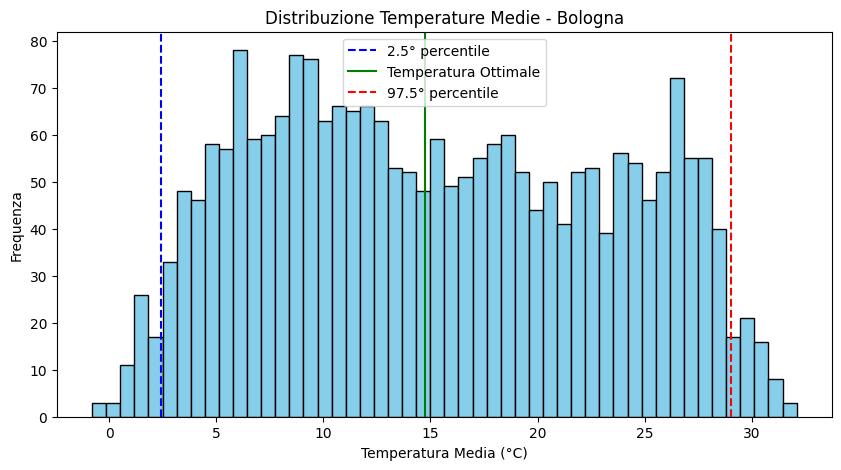

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_final['tmed'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(p2_5, color='blue', linestyle='--', label='2.5° percentile')
plt.axvline(optimal_temp, color='green', linestyle='-', label='Temperatura Ottimale')
plt.axvline(p97_5, color='red', linestyle='--', label='97.5° percentile')
plt.legend()
plt.title('Distribuzione Temperature Medie - Bologna')
plt.xlabel('Temperatura Media (°C)')
plt.ylabel('Frequenza')
plt.show()


In [ ]:
df_final['temp_category'] = df_final['tmed'].apply(classify_temp_gasparrini)


In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople,over65,under5,pct_over65,pct_under5,temp_category
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551,249176,48736,24.487814,4.789539,Extreme Cold
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold
...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Cold
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat


In [ ]:
print(df_final['temp_category'].value_counts())

temp_category
Moderate Cold    1119
Moderate Heat    1116
Extreme Heat       59
Extreme Cold       56
Name: count, dtype: int64


### Integrazione dei Dati Epidemiologici da Studi Internazionali

Nel nostro progetto **non possediamo dati di mortalità locali dettagliati** che colleghino direttamente ogni giornata a esiti sanitari specifici.  

Per superare parzialmente questa limitazione, abbiamo deciso di integrare nel nostro dataset finale i risultati degli studi epidemiologici pubblicati da Gasparrini et al. (2015). Tali studi stimano, per diversi Paesi (Italia inclusa), la **percentuale di mortalità attribuibile** a ciascuna categoria termica, derivata da analisi di serie temporali sul periodo 1985-2015.  

**Approccio metodologico adottato:**

- abbiamo estratto dal dataset `df_death` i valori relativi all'Italia, che indicano la quota percentuale di decessi associata a ciascuna condizione termica (es. 0.85% per Extreme Cold, 8.51% per Moderate Cold, ecc.);
- abbiamo creato una mappa di corrispondenza tra ciascuna categoria termica e il relativo rischio percentuale di mortalità;
- abbiamo applicato tale mappatura al nostro dataset climatico (`df_final`), assegnando a ogni giornata un valore indicativo di **rischio teorico di mortalità attribuibile**, basato sui dati epidemiologici italiani.

Questa scelta metodologica ci consente di:

- arricchire il nostro dataset con **indicatori epidemiologici di vulnerabilità**, anche in assenza di dati locali specifici ed anche se sappiamo che è soltanto una stima;
- individuare, a livello teorico, **quali giornate potrebbero comportare un rischio sanitario più elevato**, orientando eventuali strategie di prevenzione;

**Limiti importanti di questo approccio:**

- i valori di `df_death` rappresentano medie nazionali e **non riflettono necessariamente il rischio locale di Bologna**;
- servono esclusivamente come riferimento epidemiologico per contestualizzare il rischio potenziale associato alle condizioni termiche.

Nonostante tali limiti, l'integrazione di queste stime rappresenta uno strumento utile per costruire una visione preliminare del rischio climatico-sanitario a Bologna, in attesa di eventuali dati epidemiologici più specifici.


### Simulazione del Rischio Giornaliero in Funzione della Distanza dalla Temperatura Ottimale

Nei modelli epidemiologici tradizionali, il rischio attribuibile a categorie termiche moderate (es. Moderate Cold o Moderate Heat) viene spesso considerato **costante** all’interno dell’intervallo definito dai percentili di soglia. Tuttavia, questa ipotesi è semplificativa: il rischio di mortalità **non è uniforme** ma cresce man mano che ci si allontana dalla Temperatura Ottimale (OT).

**Per simulare in maniera più realistica l’impatto sanitario giornaliero, abbiamo deciso di applicare un approccio proporzionale:**  

- nelle fasce Moderate Cold (MC) e Moderate Heat (MH), il rischio attribuibile viene modulato in base alla distanza dalla Temperatura Ottimale;
- il rischio cresce linearmente man mano che ci si avvicina ai limiti estremi (percentili 2.5° o 97.5°);
- i valori estremi (Extreme Cold, Extreme Heat) vengono invece mantenuti costanti, come indicato dagli studi di Gasparrini et al. (2015).


In [ ]:
# Filtro dei dati d'Italia
italy_death = df_death[df_death['country'] == 'Italy'].iloc[0]

# Definizione dei rischi medi per ciascuna categoria
death_mapping = {
    'Extreme Cold': italy_death['ec'],
    'Moderate Cold': italy_death['mc'],
    'Moderate Heat': italy_death['mh'],
    'Extreme Heat': italy_death['eh']
}

# Funzione per stimare il rischio proporzionale
def estimate_risk(row, death_mapping, optimal_temp, p2_5, p97_5):
    cat = row['temp_category']
    tmed = row['tmed']

    if cat == 'Moderate Cold':
        distance = optimal_temp - tmed
        total_distance = optimal_temp - p2_5
        proportion = distance / total_distance if total_distance > 0 else 0
        return death_mapping['Moderate Cold'] * proportion

    elif cat == 'Moderate Heat':
        distance = tmed - optimal_temp
        total_distance = p97_5 - optimal_temp
        proportion = distance / total_distance if total_distance > 0 else 0
        return death_mapping['Moderate Heat'] * proportion

    else:
        # Per EC e EH, valore fisso medio
        return death_mapping.get(cat, 0)

# Applicazione al DataFrame
df_final['mortality_risk_pct'] = df_final.apply(
    estimate_risk,
    axis=1,
    args=(death_mapping, optimal_temp, p2_5, p97_5)
)

# Visualizzazione dei risultati
print(df_final[['Data', 'tmed', 'temp_category', 'mortality_risk_pct']].head())

        Data  tmed  temp_category  mortality_risk_pct
0 2019-01-03   2.0   Extreme Cold            0.850000
1 2019-01-10   3.8  Moderate Cold            7.545304
2 2019-01-12   2.7  Moderate Cold            8.303279
3 2019-01-13   4.1  Moderate Cold            7.338583
4 2019-01-14   7.6  Moderate Cold            4.926842


In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople,over65,under5,pct_over65,pct_under5,temp_category,mortality_risk_pct
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551,249176,48736,24.487814,4.789539,Extreme Cold,0.850000
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,7.545304
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,8.303279
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,7.338583
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,4.926842
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.069130
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Cold,0.034453
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.424654
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.187638


### Trasformazione della Variabile `temp_category` in Codice Numerico

Nei passaggi precedenti abbiamo costruito la variabile `temp_category` come stringa, contenente le seguenti etichette testuali:

- `"Extreme Cold"`
- `"Moderate Cold"`
- `"Moderate Heat"`
- `"Extreme Heat"`

**Per motivi di efficienza computazionale e coerenza nelle analisi successive,** abbiamo deciso di convertire questa variabile in un valore intero.

Abbiamo adottato la seguente codifica:

| Categoria termica | Codice numerico |
|--------------------|-----------------|
| Extreme Cold       | 1               |
| Moderate Cold      | 2               |
| Moderate Heat      | 3               |
| Extreme Heat       | 4               |


### Codice Python per la Trasformazione


In [ ]:
# Definizione della mappa di conversione
temp_category_mapping = {
    'Extreme Cold': 1,
    'Moderate Cold': 2,
    'Moderate Heat': 3,
    'Extreme Heat': 4
}

# Creazione di una nuova colonna numerica
df_final['temp_category_code'] = df_final['temp_category'].map(temp_category_mapping)

# Controllo del risultato
print(df_final[['Data', 'tmed', 'temp_category', 'temp_category_code']].head())


        Data  tmed  temp_category  temp_category_code
0 2019-01-03   2.0   Extreme Cold                   1
1 2019-01-10   3.8  Moderate Cold                   2
2 2019-01-12   2.7  Moderate Cold                   2
3 2019-01-13   4.1  Moderate Cold                   2
4 2019-01-14   7.6  Moderate Cold                   2


In [ ]:
# C'erano dati sbagliati con dati d'Inverno 2025
# Filtra eliminando invierno 2025
df_final = df_final[~((df_final['period'] == 2025) & (df_final['season'] == 4))]

In [ ]:
df_final

,Data,tmed,tmax,tmin,season,period,numPeople,over65,under5,pct_over65,pct_under5,temp_category,mortality_risk_pct,temp_category_code
0,2019-01-03,2.0,6.8,-1.9,4,2019,1017551,249176,48736,24.487814,4.789539,Extreme Cold,0.850000,1
1,2019-01-10,3.8,8.2,-1.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,7.545304,2
2,2019-01-12,2.7,8.0,-1.4,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,8.303279,2
3,2019-01-13,4.1,10.2,-1.0,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,7.338583,2
4,2019-01-14,7.6,14.7,0.1,4,2019,1017551,249176,48736,24.487814,4.789539,Moderate Cold,4.926842,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2025-05-16,15.8,20.1,11.7,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.069130,3
2346,2025-05-23,14.7,18.2,11.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Cold,0.034453,2
2347,2025-05-26,21.2,27.5,15.4,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.424654,3
2348,2025-05-27,17.6,20.2,14.3,1,2025,1020865,254982,41839,24.977054,4.098387,Moderate Heat,0.187638,3


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2271 entries, 0 to 2349
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Data                2271 non-null   datetime64[ns]
 1   tmed                2271 non-null   float64       
 2   tmax                2271 non-null   float64       
 3   tmin                2271 non-null   float64       
 4   season              2271 non-null   int64         
 5   period              2271 non-null   int32         
 6   numPeople           2271 non-null   int64         
 7   over65              2271 non-null   int64         
 8   under5              2271 non-null   int64         
 9   pct_over65          2271 non-null   float64       
 10  pct_under5          2271 non-null   float64       
 11  temp_category       2271 non-null   object        
 12  mortality_risk_pct  2271 non-null   float64       
 13  temp_category_code  2271 non-null   int64         
dt

In [ ]:
df_final.to_csv('bolognaRiskDataset.csv', index=False)

Per esempio, per controllare l'utilizzo adeguato di DateTime nella colonna `Data`

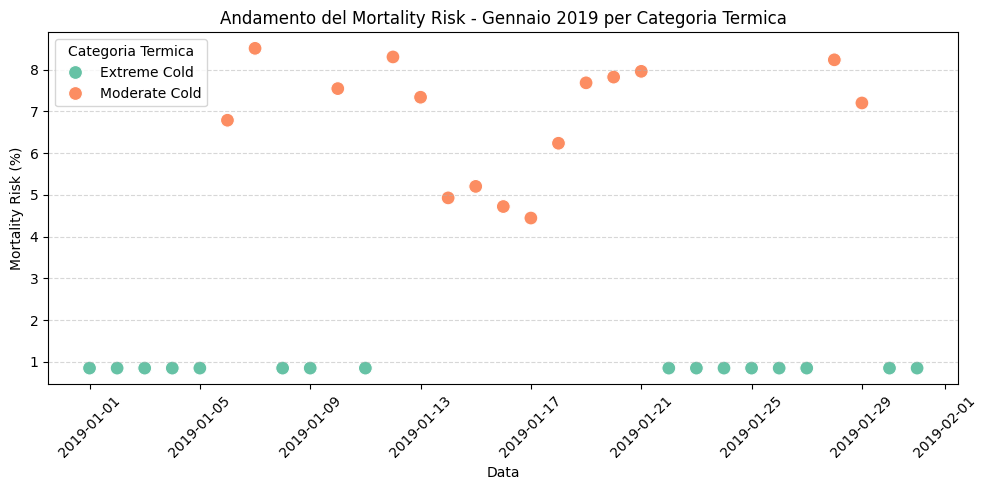

In [ ]:
mask = (
    (df_final['Data'].dt.year == 2019) &
    (df_final['Data'].dt.month == 1)
)

plt.figure(figsize=(10,5))

sns.scatterplot(
    x=df_final.loc[mask, 'Data'],
    y=df_final.loc[mask, 'mortality_risk_pct'],
    hue=df_final.loc[mask, 'temp_category'],
    palette='Set2',
    s=100
)

plt.title('Andamento del Mortality Risk - Gennaio 2019 per Categoria Termica')
plt.xlabel('Data')
plt.ylabel('Mortality Risk (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Categoria Termica')
plt.tight_layout()
plt.show()

### Contenuto del Dataset `bolognaRiskDataset.csv`

Il file CSV finale contiene 14 colonne e 2.350 righe (una per ciascun giorno dal 2019 al 2025), tra cui:

- Data
- Temperature (medie, minime, massime)
- Variabili demografiche
- Percentuali di popolazione vulnerabile
- Categoria termica testuale e numerica
- Rischio di mortalità teorico attribuito alla condizione climatica